In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import re
import phik
import warnings

from tqdm.notebook import trange, tqdm
from time import sleep
from pandas_profiling import ProfileReport
from phik import report
from phik.report import plot_correlation_matrix

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
tqdm.pandas()

/var/folders/9k/d4fyk_ln6fl967dj3qpntlfr0000gn/T/ipykernel_15337/478393431.py:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [38]:
df = pd.read_csv('/Users/prime/Documents/data/kaggle/cars Russia/archive/region25_en.csv')

# Подготовка данных

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513200 entries, 0 to 1513199
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   brand                 1513200 non-null  object 
 1   name                  1513200 non-null  object 
 2   bodyType              1513200 non-null  object 
 3   color                 1403466 non-null  object 
 4   fuelType              1509640 non-null  object 
 5   year                  1102226 non-null  float64
 6   mileage               1498720 non-null  float64
 7   transmission          1510135 non-null  object 
 8   power                 1492313 non-null  float64
 9   price                 1513200 non-null  int64  
 10  vehicleConfiguration  1102226 non-null  object 
 11  engineName            1101142 non-null  object 
 12  engineDisplacement    1092435 non-null  object 
 13  date                  1513200 non-null  object 
 14  location              1513200 non-

In [40]:
df.columns = ['brand', 'name', 'body_type', 'color', 'fuel_type', 'year', 'mileage',
       'transmission', 'power', 'price', 'vehicle_configuration', 'engine_name',
       'engine_displacement', 'date', 'location', 'link', 'parse_date']

In [41]:
def check(df):
    l = []
    columns = df.columns
    for col in tqdm(columns):
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        len_col = len(df[col])
        sum_nan = df[col].isna().sum()
        count = df[col].count()
        per_nan = sum_nan/len_col * 100
        l.append([col, dtypes, nunique, len_col, sum_nan, count, per_nan])
    df_check = pd.DataFrame(l)
    df_check.columns=['column', 'dtypes', 'nunique', 'len_col', 'sum_nan', 'count', 'per_nan']
    return df_check

df_check = check(df)

  0%|          | 0/17 [00:00<?, ?it/s]

In [42]:
df_check.sort_values(by = 'per_nan', ascending=False)

,column,dtypes,nunique,len_col,sum_nan,count,per_nan
12,engine_displacement,object,55,1513200,420765,1092435,27.81
11,engine_name,object,1149,1513200,412058,1101142,27.23
5,year,float64,59,1513200,410974,1102226,27.16
10,vehicle_configuration,object,7955,1513200,410974,1102226,27.16
3,color,object,15,1513200,109734,1403466,7.25
8,power,float64,352,1513200,20887,1492313,1.38
6,mileage,float64,541,1513200,14480,1498720,0.96
4,fuel_type,object,3,1513200,3560,1509640,0.24
7,transmission,object,5,1513200,3065,1510135,0.20
15,link,object,50119,1513200,0,1513200,0.00


In [43]:
print(f'Количество дупликатов = {df.duplicated().sum()}')
display(df[df.duplicated()])

Количество дупликатов = 13992


,brand,name,body_type,color,fuel_type,year,mileage,transmission,power,price,vehicle_configuration,engine_name,engine_displacement,date,location,link,parse_date
5320,Toyota,Hilux Surf,jeep 5 doors,white,Gasoline,NaN,270000.00,AT,150.00,600000,NaN,NaN,NaN,2022-08-19 00:00:00,Kavalerovo,https://kavalerovo.drom.ru/toyota/hilux_surf/4...,2022-08-20 06:00:00
10800,Toyota,Caldina,station wagon,grey,Gasoline,1996.00,188000.00,Manual,100.00,90000,1.5 U,5E-FE,1.5 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/caldina/473...,2022-08-20 09:00:00
10801,Toyota,RAV4,jeep 5 doors,green,Gasoline,1995.00,107000.00,AT,135.00,455000,2.0 J V,3S-FE,2.0 LTR,2022-08-20 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/rav4/468426...,2022-08-20 09:00:00
13100,Toyota,Mark X,sedan,white,Gasoline,NaN,240000.00,AT,203.00,1250000,NaN,NaN,NaN,2022-08-19 00:00:00,Ussurijsk,https://ussuriisk.drom.ru/toyota/mark_x/465602...,2022-08-20 10:00:00
13460,Lexus,GX470,jeep 5 doors,grey,Gasoline,NaN,212000.00,AT,263.00,1930000,NaN,NaN,NaN,2022-08-19 00:00:00,Vladivostok,https://vladivostok.drom.ru/lexus/gx470/461209...,2022-08-20 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510280,Toyota,C-HR,jeep 5 doors,NaN,Gasoline,2017.00,37000.00,CVT,116.00,1685000,1.2 G-T LED Edition 4WD,8NR-FTS,1.2 LTR,2022-09-26 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/c-hr/483732...,2022-09-26 18:00:00
1511240,Toyota,Camry,sedan,white,Gasoline,2018.00,15000.00,AT,181.00,2990000,2.5 AT Престиж Safety,2AR-FE,2.5 LTR,2022-09-26 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/camry/45668...,2022-09-26 18:00:00
1511520,Mitsubishi,Delica,minivan,grey,Diesel,NaN,283000.00,AT,85.00,430000,NaN,NaN,NaN,2022-09-26 00:00:00,Nahodka,https://nakhodka.drom.ru/mitsubishi/delica/476...,2022-09-26 18:00:00
1511521,Toyota,Corolla Fielder,station wagon,white,Gasoline,2013.00,53000.00,CVT,74.00,830000,1.5 Hybrid,1NZ-FXE,1.5 LTR,2022-09-26 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/corolla_fie...,2022-09-26 18:00:00


In [44]:
display(df.sample(20))

,brand,name,body_type,color,fuel_type,year,mileage,transmission,power,price,vehicle_configuration,engine_name,engine_displacement,date,location,link,parse_date
390577,Suzuki,Alto,hatchback 5 doors,white,Gasoline,2014.00,69000.00,Robot,49.00,430000,Van 660 VP,R06A,0.7 LTR,2022-08-29 00:00:00,Vladivostok,https://vladivostok.drom.ru/suzuki/alto/480044...,2022-08-29 14:00:00
305151,Mazda,Demio,hatchback 5 doors,black,Gasoline,NaN,124000.00,CVT,90.00,480000,NaN,NaN,NaN,2022-08-27 00:00:00,Artem,https://artem.drom.ru/mazda/demio/47046926.html,2022-08-27 18:00:00
1319194,Toyota,Crown,sedan,grey,Gasoline,1994.00,250000.00,AT,180.00,150000,2.5 Royal touring,1JZ-GE,2.5 LTR,2022-09-20 00:00:00,Ussurijsk,https://ussuriisk.drom.ru/toyota/crown/4810775...,2022-09-20 08:00:00
1507780,Lada,4x4 2121 Niva,jeep 3 doors,yellow,Gasoline,NaN,36000.00,Manual,80.00,120000,NaN,NaN,NaN,2022-09-26 00:00:00,Arsenev,https://arsenyev.drom.ru/lada/2121_4x4_niva/48...,2022-09-26 16:00:00
1401257,Suzuki,Jimny,jeep 3 doors,white,Gasoline,2010.00,113000.00,Manual,64.00,645000,660 X Adventure XA 4WD,K6A,0.7 LTR,2022-09-22 00:00:00,Vladivostok,https://vladivostok.drom.ru/suzuki/jimny/46440...,2022-09-23 04:00:00
90581,Subaru,Forester,jeep 5 doors,black,Gasoline,2007.00,193000.00,AT,230.00,940000,2.0 XT platina selection 4WD,EJ20,2.0 LTR,2022-08-21 00:00:00,Vladivostok,https://vladivostok.drom.ru/subaru/forester/47...,2022-08-22 01:00:00
228459,BMW,X1,jeep 5 doors,white,Gasoline,2015.00,82000.00,AT,136.00,1499000,sDrive 18i,B38A15A,1.5 LTR,2022-08-25 00:00:00,Vladivostok,https://vladivostok.drom.ru/bmw/x1/47458214.html,2022-08-26 02:00:00
1116110,Toyota,Crown,sedan,white,Gasoline,1988.00,149000.00,AT,135.00,155000,2.0 super Deluxe (column),1G-FE,2.0 LTR,2022-09-15 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/crown/48249...,2022-09-15 18:00:00
366010,Lexus,GX460,jeep 5 doors,brown,Gasoline,NaN,210000.00,AT,296.00,3700000,NaN,NaN,NaN,2022-08-28 00:00:00,Vladivostok,https://vladivostok.drom.ru/lexus/gx460/478960...,2022-08-29 01:00:00
797473,Toyota,Crown,sedan,white,Gasoline,2014.00,140000.00,CVT,178.00,2000000,Hybrid 2.5 Athlete G,2AR-FSE,2.5 LTR,2022-09-07 00:00:00,Vladivostok,https://vladivostok.drom.ru/toyota/crown/46853...,2022-09-07 19:00:00


Датасет представлен информацией об объявлениях о продаже автомобилей в Приморском крае. Датасет собран в результате парсинга данных с сайта drom.ru и выложен на портале https://www.kaggle.com/datasets/ekibee/car-sales-information автором в открытом доступе. 
- В датасете содержится информация по 1 513 200 объявлениям (строкам) по 17 признакам (столбцам).
- В датасете имеются пропуски по следующим столбцам: `engine_displacement = 27.81%`, `engine_name = 27.23%`, `year = 27.16%`, `vehicle_configuration = 27.16%`, `color = 7.25%`, `power = 1.38%`, `mileage = 0.96%`, `fuel_type = 0.24%`, `transmission = 0.20%`. Полагаяю, что объем ДВС, год выпуска автомобиля, мощеость ДВС и пробег автомобиля являются важными характеристиками, с точки зрения влияния на стоимость автомобиля. Предполагаю, что допущенные пропуски были сделаны намеренно, с целью экономии времени при формировании объявления на сайте или для скрытия информации. Тогда как пропуски по столбцу с цветом автомобиля могли быть связаны с наличием фото и возможностью оценить цвет по нему.
- Столбцы с датой публикации объявления и датой сбора данных могут быть использованы для формирования нового признака - длительности публикации, что также может отражаться на стоимости автомобиля, так как люди склонны снижать стоимость имущества на фоне длительного ожидания покупателей, с целью сделать их предложение более предпочтительным на рынке. После создания нового признака, столбцы с датами и ссылкой на объявления можно удалить из датасета.
- В датасете присутсвует 13 992 дупликата, часть из которых помимо этого содерержит пропуски по нескольким столбцам одновременно.
- Столбце `engine_displacement` следует перевести в числовой тип данных. Столбцы с датами также следует привести к соответствующему типу данных.


**Перечень признаков:**
- `brand` - марка автомобиля
- `name` - модель автомобиля
- `body_type` - тип кузова автомобиля
- `fuel_type` - используемое топливо для автомобиля
- `mileage` - пробег автомобиля
- `transmission` - тип трансмиссии автомобиля
- `power` - мощность автомобиля
- `vehicle_configuration` - конфикурация автомобиля
- `engine_name` - модель ДВС автомобиля
- `engine_displacement` - объем ДВС автомобиля
- `location` - населенный пункт 
- `lifetime` - длительность размещения объявления о продаже автомобиля
- `age` - возраст автомобиля
- `mil_year` - среднегодовой пробег автомобиля
- `tax_low` - тариф налогооблажения автомобиля
- `country` - страна производитель
- `date` - дата публикации обхявления
- `parse_date` - дата сбора данных
- `link` - ссылка на объявление


**Целевой признак:**
- `price` - стоимость автомобиля

In [46]:
df = df.drop_duplicates().reset_index(drop = True)

In [48]:
display(df[df['year'].isna() & df['engine_displacement'].notna()].count())

brand                    0
name                     0
body_type                0
color                    0
fuel_type                0
year                     0
mileage                  0
transmission             0
power                    0
price                    0
vehicle_configuration    0
engine_name              0
engine_displacement      0
date                     0
location                 0
link                     0
parse_date               0
dtype: int64

In [49]:
len(df)

1499208

In [50]:
df.dropna(subset = ['year'], inplace = True)

In [51]:
len(df)

1092204

In [52]:
check(df)

  0%|          | 0/17 [00:00<?, ?it/s]

,column,dtypes,nunique,len_col,sum_nan,count,per_nan
0,brand,object,67,1092204,0,1092204,0.00
1,name,object,869,1092204,0,1092204,0.00
2,body_type,object,11,1092204,0,1092204,0.00
3,color,object,15,1092204,77847,1014357,7.13
4,fuel_type,object,3,1092204,9,1092195,0.00
5,year,float64,59,1092204,0,1092204,0.00
6,mileage,float64,488,1092204,13058,1079146,1.20
7,transmission,object,4,1092204,0,1092204,0.00
8,power,float64,318,1092204,9398,1082806,0.86
9,price,int64,2743,1092204,0,1092204,0.00


In [53]:
for col in tqdm(['color', 'mileage', 'power', 'engine_name', 'engine_displacement']):
    df[col] = df.groupby([
        'brand', 'name', 'year', 'vehicle_configuration'])[col].apply(lambda x: x.fillna(x.mode(dropna=False)[0]))

  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
df.isna().sum()

brand                        0
name                         0
body_type                    0
color                    39932
fuel_type                    9
year                         0
mileage                  11172
transmission                 0
power                     9398
price                        0
vehicle_configuration        0
engine_name               1072
engine_displacement       9709
date                         0
location                     0
link                         0
parse_date                   0
dtype: int64

In [55]:
len(df)

1092204

In [56]:
df = df.dropna().reset_index()

In [57]:
len(df)

1032000

In [58]:
df['engine_displacement'] = df['engine_displacement'].progress_apply(lambda x: re.sub("[^0-9.]", "", x))

  0%|          | 0/1032000 [00:00<?, ?it/s]

In [59]:
convert_dict = {"year": int, 
                "mileage": int,
                "power": int,
                "engine_displacement": float,
                "date": 'datetime64',
                "parse_date": 'datetime64'
               } 
  
df = df.astype(convert_dict)

In [60]:
display(df['name'].value_counts())
print(df.shape)

Land Cruiser Prado    53936
Prius                 41317
Harrier               31454
Fit                   27588
Corolla Fielder       24400
                      ...  
LS400                     2
Tracker                   2
BT-50                     1
Rafaga                    1
Galloper                  1
Name: name, Length: 840, dtype: int64

(1032000, 18)


In [61]:
shape_name_old = df.shape[0]

group_count = df.groupby('name')['price'].count()
drop_models = group_count[group_count <=15].index
df = df[~df['name'].isin(drop_models)]

print("Разница после преобразования:", shape_name_old - df.shape[0])

Разница после преобразования: 629


- Удалены все дупликаты.
- Пропуски по году выпуска автомобиля были также сопряжены с пропусками в информации об объеме ДВС, комплектации и модели двигателя, что лишает нас возможности восстановить их, основываясь на оставшихся признаках. Эти данные являются важными для формирвоания прогноза, поэтому было принято решение избавиться от них.
- Пропуски по оставшимся признакам был частично востановлены с помощью моды признака по групповому срезу.
- Оставшиеся пропуски были удалены из датасета.
- Изменены типы данных следующих столбцов: `year: int`, `mileage: int`, `power: int`, `engine_displacement: float`, `date: datetime64`, `parse_date: datetime64`.
- Из датасета удалена информация о моделях автомобилей, по которым число объявлений меньше 15. Таких объявлений было 629.

# Фичинженеринг

In [63]:
df['lifetime'] = df['parse_date'] - df['date']
df['lifetime'] = df['lifetime'].astype('timedelta64[h]')
df = df.drop(['index', 'link', 'parse_date', 'date'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031371 entries, 0 to 1031999
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   brand                  1031371 non-null  object 
 1   name                   1031371 non-null  object 
 2   body_type              1031371 non-null  object 
 3   color                  1031371 non-null  object 
 4   fuel_type              1031371 non-null  object 
 5   year                   1031371 non-null  int64  
 6   mileage                1031371 non-null  int64  
 7   transmission           1031371 non-null  object 
 8   power                  1031371 non-null  int64  
 9   price                  1031371 non-null  int64  
 10  vehicle_configuration  1031371 non-null  object 
 11  engine_name            1031371 non-null  object 
 12  engine_displacement    1031371 non-null  float64
 13  location               1031371 non-null  object 
 14  lifetime          

In [64]:
df['age'] = 2022 - df['year']

In [65]:
df['age'].min()

0

In [66]:
def mil_year(df):
    if df['age'] != 0:
        a = round((df['mileage'] / df['age']), 0)
    else:
        a = round((df['mileage']), 0)
    return a

In [67]:
df['mil_year'] = df.progress_apply(mil_year, axis=1)
df['mil_year'] = df['mil_year'].astype('int64')

  0%|          | 0/1031371 [00:00<?, ?it/s]

In [68]:
df['tax_low'] = pd.cut(df['power'], bins=[0, 249, df['power'].max()], labels=['1', '0'])
df['tax_low'] = df['tax_low'].astype('category')

In [69]:
brand_list = set(df['brand'])
print(brand_list)

{'Volvo', 'UAZ', 'Peugeot', 'Ram', 'Exeed', 'Maserati', 'IZh', 'Hyundai', 'Cadillac', 'Lada', 'Dodge', 'Smart', 'BMW', 'Haval', 'Chrysler', 'Toyota', 'Fiat', 'Datsun', 'Nissan', 'Suzuki', 'Renault', 'Bentley', 'Moskvich', 'Isuzu', 'Jaguar', 'Ford', 'SsangYong', 'Genesis', 'Lexus', 'Opel', 'Vortex', 'Honda', 'Jeep', 'Kia', 'Rover', 'Citroen', 'Acura', 'Zotye', 'Volkswagen', 'Lincoln', 'Daewoo', 'Chevrolet', 'LuAZ', 'ZAZ', 'Mini', 'Porsche', 'Subaru', 'Hummer', 'Skoda', 'Mazda', 'Mitsubishi', 'Chery', 'Infiniti', 'Audi', 'GAZ', 'Mercedes-Benz', 'Land Rover', 'Daihatsu', 'Geely'}


In [70]:
country_brand = {
    'Russia': ['UAZ', 'GAZ', 'Moskvich', 'ZAZ', 'IZh', 'Lada'],
    'Great Britain': ['Jaguar', 'Bentley', 'Land Rover', 'Rover'],
    'Japan': ['Nissan', 'Infiniti', 'Isuzu', 'Mazda', 'Mitsubishi', 'Toyota', 'Daihatsu', 'Datsun', 'Lexus', 'Acura', 'Subaru', 'Suzuki', 'Honda'],
    'Germany': ['Mini', 'Mercedes-Benz', 'BMW', 'Audi', 'Volkswagen', 'Opel', 'Smart', 'Porsche'],
    'USA': ['Chrysler', 'Vortex', 'Lincoln', 'Cadillac', 'Jeep', 'Dodge', 'Ford', 'Hummer', 'Ram', 'Chevrolet'],
    'South Korea': ['Genesis', 'Kia', 'Daewoo', 'Hyundai'],
    'China': ['Zotye', 'SsangYong', 'Exeed', 'Geely', 'Haval', 'Chery'],
    'France': ['Peugeot', 'Citroen', 'Renault'],
    'Sweden': ['Volvo'],
    'Italy': ['Maserati', 'Fiat'],
    'Ukraine': ['LuAZ'],
    'Czech': ['Skoda']
}

In [71]:
country = list(country_brand.keys())
brand = list(country_brand.values())

df_country_brand = pd.DataFrame(list(zip(country_brand.keys(), country_brand.values())), columns = [
    'key', 'value'])
df_country_brand = df_country_brand.explode('value')

brand = list(df_country_brand['value'])
country = list(df_country_brand['key'])

brand_country = dict(zip(brand, country))

In [72]:
df['country'] = df['brand']

df['country'] = df['country'].replace(brand_country)
display(df.sample(10))

,brand,name,body_type,color,fuel_type,year,mileage,transmission,power,price,vehicle_configuration,engine_name,engine_displacement,location,lifetime,age,mil_year,tax_low,country
833309,Toyota,Vitz,hatchback 5 doors,grey,Gasoline,2017,122000,CVT,95,755000,1.3 F 4WD,1NR-FE,1.30,Vladivostok,27.00,5,24400,1,Japan
651111,Toyota,Prius,liftback,silver,Gasoline,2009,120000,CVT,99,975000,1.8 G touring selection,2ZR-FXE,1.80,Vladivostok,21.00,13,9231,1,Japan
1031582,Nissan,Murano,jeep 5 doors,orange,Gasoline,2005,245000,CVT,234,580000,3.5 CVT SE,VQ35DE,3.50,Nahodka,19.00,17,14412,1,Japan
627091,Toyota,Crown,sedan,black,Gasoline,2016,142000,AT,235,2185000,2.0 Athlete S-T,8AR-FTS,2.00,Vladivostok,28.00,6,23667,1,Japan
69217,Subaru,Exiga,minivan,violet,Gasoline,2009,170000,AT,225,665000,2.0 GT 4WD,EJ20,2.00,Vladivostok,29.00,13,13077,1,Japan
309887,Nissan,Wingroad,station wagon,grey,Gasoline,2008,165000,CVT,128,385000,1.8 18G authentic Axis,MR18DE,1.80,Vladivostok,17.00,14,11786,1,Japan
825083,Toyota,Ractis,hatchback 5 doors,silver,Gasoline,2012,150000,CVT,95,555000,1.3 X V Package,1NR-FE,1.30,Vladivostok,21.00,10,15000,1,Japan
402827,Honda,Insight,liftback,grey,Gasoline,2011,135000,CVT,111,849000,1.5 Exclusive XG,LEA,1.50,Nahodka,14.00,11,12273,1,Japan
58492,Toyota,Land Cruiser,jeep 5 doors,black,Gasoline,2016,87000,AT,309,6250000,4.6 AT Executive,1UR-FE,4.60,Vladivostok,22.00,6,14500,0,Japan
153775,Lexus,GX460,jeep 5 doors,grey,Gasoline,2013,120000,AT,296,4390000,4.6 AT Premium 7S,1UR-FE,4.60,Nahodka,22.00,9,13333,0,Japan


- Как и планировалось ранее на основании информации о датах публикации объявлений и датах сбора данных создан новый признак - `lifetime` с информацией о длительности публикации объявления. После чего лишнии столбцы были удалены из датасета.
- На основании информации о годе выпуска создан признак с возрастом автомобилей - `age`.
- При помощи информации о возрасте автомобиля и пробеге извлечена информация о среднегодовом пробеге автомобилей. По данной информации можно косвенно судить о предполагаемом состоянии автомобиля и сделать предположение и цели использования транспортного средства - `mil_year`.
- Учитывая тарифы налогооблажения за владение транспортным средством на основании мощности автомобилей создан категориальный признак `tax_low`.
- На основании принадлежности марки автомобиля определенной стране производителя создан признак `country`.

# Анализ данных

In [75]:
def describe_plus(df):
    l = []
    for col in tqdm(df.columns):
        if (df[col].dtype == np.float64 or df[col].dtype == np.int64):
            count = df[col].count()
            mean = df[col].mean()
            std = df[col].std()
            min_n = df[col].min()
            per_1, per_25, per_50, per_75, per_99 = np.percentile(df[col], [
                1, 25, 50, 75, 99
            ])
            max_n = df[col].max()
            iqr = per_75 - per_25
            min_1_5_iqr = per_25 - 1.5*iqr
            if min_1_5_iqr < min_n:
                min_1_5_iqr = min_n

            max_1_5_iqr = per_75 + 1.5*iqr
            if max_1_5_iqr > max_n:
                max_1_5_iqr = max_n

            l.append([
                col, count, mean, std, min_n, per_1, per_25, per_50, per_75, per_99, max_n, iqr, min_1_5_iqr, max_1_5_iqr
            ])
    df_describe = pd.DataFrame(l)
    df_describe.columns = [
        'column', 'count', 'mean', 'std', 'min', '1%', '25%', '50%', '75%', '99%', 'max', 'iqr', '-1.5iqr', '+1.5iqr'
    ]
    df_describe = df_describe.set_index('column')
    return df_describe

In [76]:
df_describe = describe_plus(df)
display(df_describe.T)

  0%|          | 0/19 [00:00<?, ?it/s]

column,year,mileage,power,price,engine_displacement,lifetime,age,mil_year
count,1031371.00,1031371.00,1031371.00,1031371.00,1031371.00,1031371.00,1031371.00,1031371.00
mean,2010.14,127981.94,149.54,1484202.48,2.07,21.30,11.86,11903.31
std,7.59,82060.97,72.46,1673000.30,0.90,9.31,7.59,6113.83
min,1948.00,1000.00,30.00,20000.00,0.50,0.00,0.00,14.00
1%,1990.00,1000.00,52.00,100000.00,0.70,1.00,2.00,77.00
25%,2006.00,69000.00,99.00,570000.00,1.50,15.00,6.00,7923.00
50%,2012.00,119000.00,135.00,950000.00,1.80,21.00,10.00,11250.00
75%,2016.00,179000.00,174.00,1810000.00,2.50,29.00,16.00,15000.00
99%,2020.00,350000.00,405.00,7800000.00,5.50,40.00,32.00,30000.00
max,2022.00,1000000.00,625.00,41500000.00,6.40,50.00,74.00,125000.00


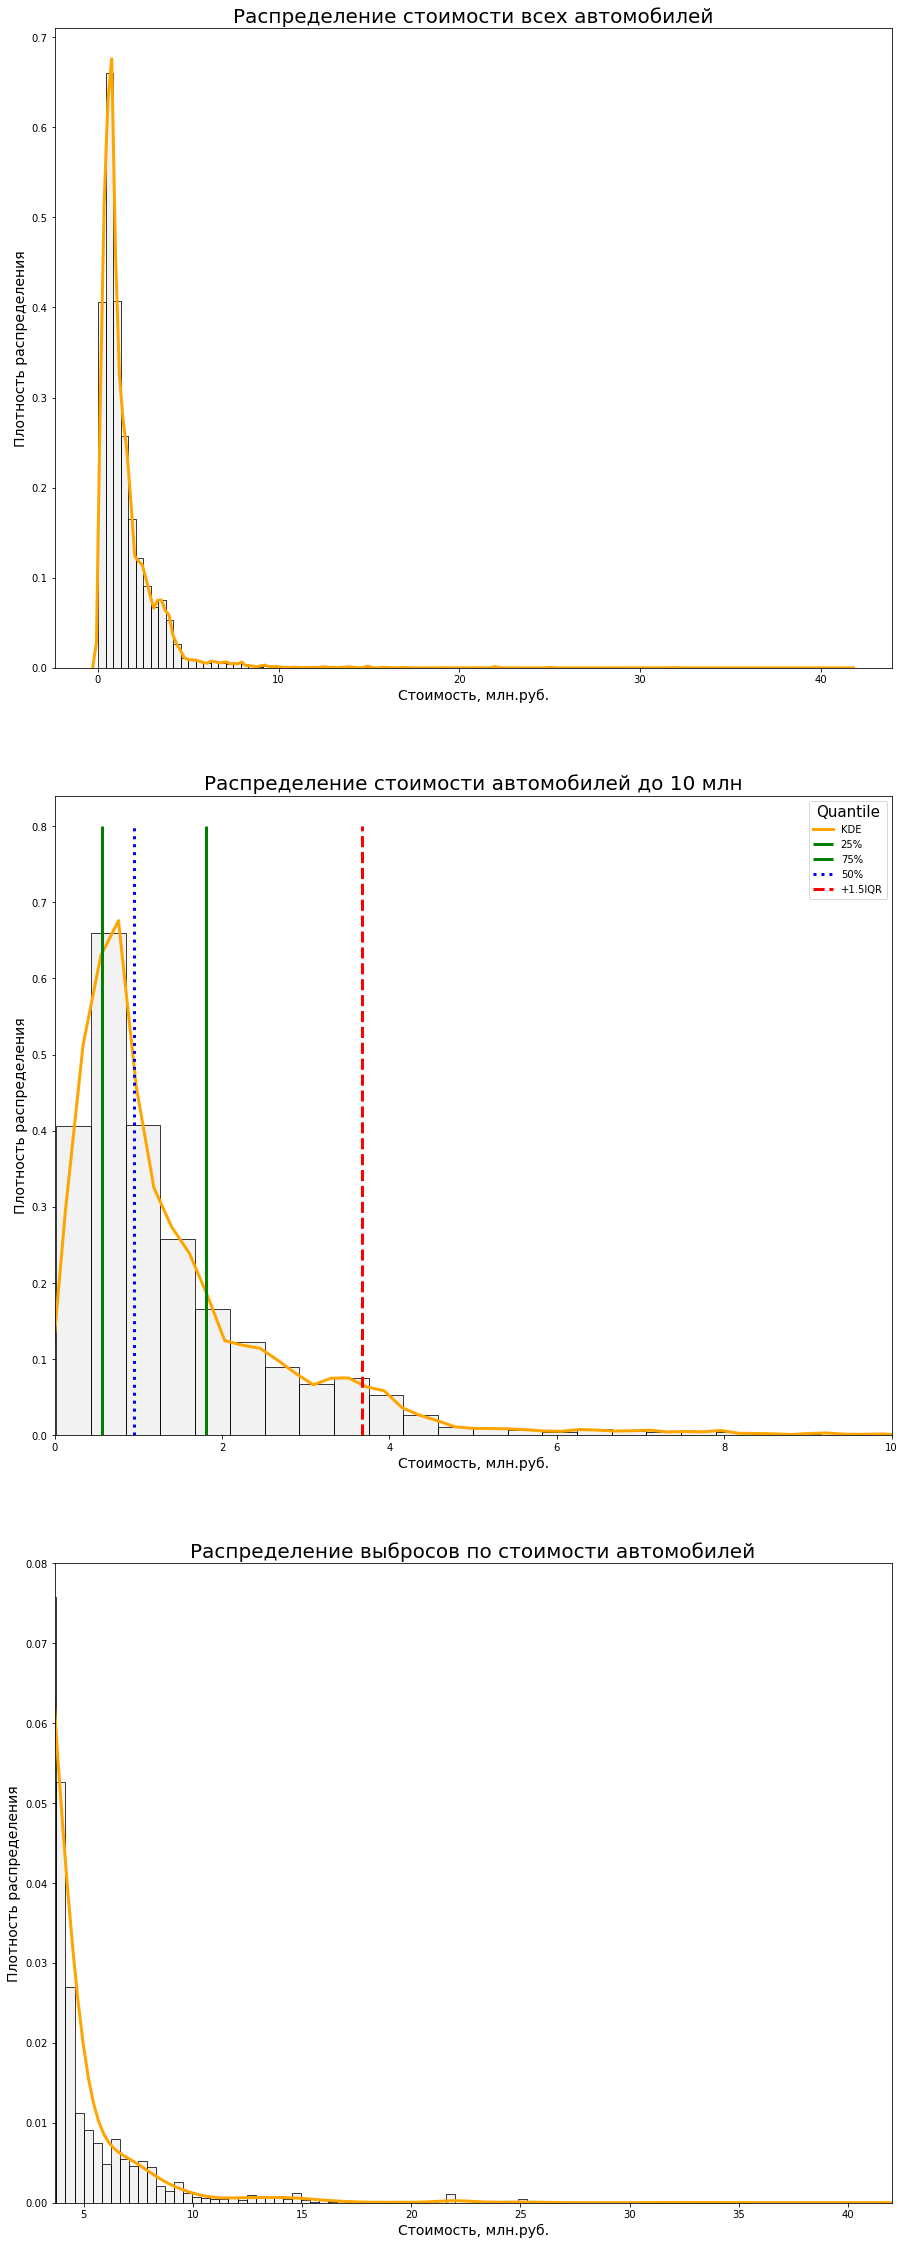

In [77]:
price_mln = df['price'] / 1000000

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 40))

sns.histplot(x=price_mln, bins=100, color='grey', stat='density', alpha=.1, ax=ax[0])
sns.kdeplot(x=price_mln, color='orange', linewidth=3, ax=ax[0])
ax[0].set_title('Распределение стоимости всех автомобилей', fontsize=20)
ax[0].set_xlabel('Стоимость, млн.руб.', fontsize=14)
ax[0].set_ylabel('Плотность распределения', fontsize=14)


sns.histplot(x=price_mln, bins=100, color='grey', stat='density', alpha=.1, ax=ax[1])
sns.kdeplot(x=price_mln, color='orange', label="KDE", linewidth=3, ax=ax[1])
ax[1].set_xlim([0, 10])
ax[1].vlines(np.percentile(price_mln, 25), 0, .8, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[1].vlines(np.percentile(price_mln, 75), 0, .8, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[1].vlines(np.percentile(price_mln, 50), 0, .8, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[1].vlines(np.percentile(price_mln, 75) + 1.5*(np.percentile(price_mln, 75) - np.percentile(price_mln, 25)),
             0, .8, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[1].set_title('Распределение стоимости автомобилей до 10 млн', fontsize=20)
ax[1].set_xlabel('Стоимость, млн.руб.', fontsize=14)
ax[1].set_ylabel('Плотность распределения', fontsize=14)
ax[1].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')


sns.histplot(x=price_mln, bins=100, color='grey', stat='density', alpha=.1, ax=ax[2])
sns.kdeplot(x=price_mln, color='orange', linewidth=3, bw_method=.5, ax=ax[2])
ax[2].set_xlim([np.percentile(price_mln, 75) + 1.5 *
               (np.percentile(price_mln, 75) - np.percentile(price_mln, 25)), 42])
ax[2].set_ylim([0, .08])
ax[2].set_title('Распределение выбросов по стоимости автомобилей', fontsize=20)
ax[2].set_xlabel('Стоимость, млн.руб.', fontsize=14)
ax[2].set_ylabel('Плотность распределения', fontsize=14)

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.show()

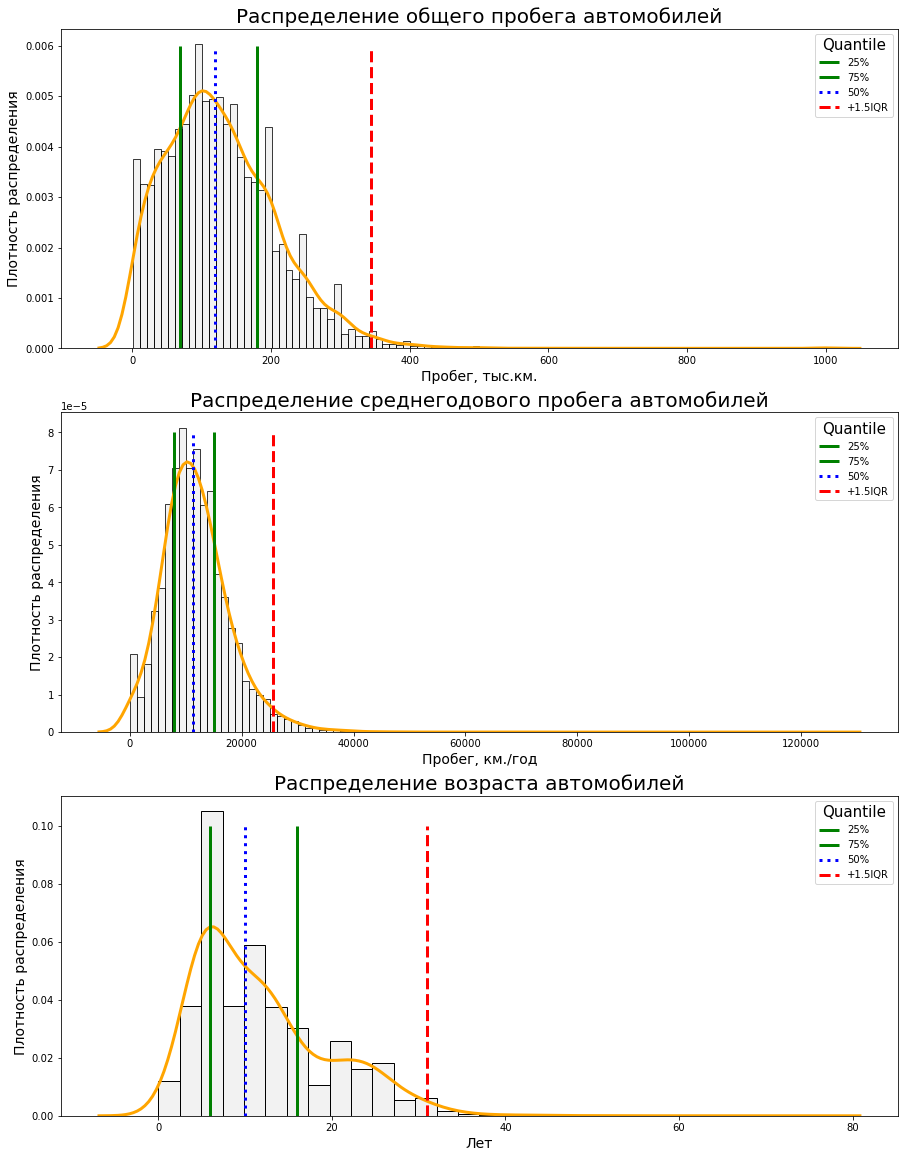

In [105]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

sns.histplot(x=df['mileage'] / 1000, bins=100,
             color='grey', stat='density', alpha=.1, ax=ax[0])
sns.kdeplot(x=df['mileage'] / 1000, color='orange',
            linewidth=3, bw_method=.2, ax=ax[0])
ax[0].set_title('Распределение общего пробега автомобилей', fontsize=20)
ax[0].set_xlabel('Пробег, тыс.км.', fontsize=14)
ax[0].set_ylabel('Плотность распределения', fontsize=14)
ax[0].vlines(np.percentile(df['mileage'] / 1000, 25), 0, .006, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[0].vlines(np.percentile(df['mileage'] / 1000, 75), 0, .006, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[0].vlines(np.percentile(df['mileage'] / 1000, 50), 0, .006, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[0].vlines(np.percentile(df['mileage'] / 1000, 75) + 1.5*(np.percentile(df['mileage'] / 1000, 75) - np.percentile(df['mileage'] / 1000, 25)),
             0, .006, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[0].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')

sns.histplot(x=df['mil_year'], bins=100,
             color='grey', stat='density', alpha=.1, ax=ax[1])
sns.kdeplot(x=df['mil_year'], color='orange',
            linewidth=3, bw_method=.3, ax=ax[1])
ax[1].set_title('Распределение среднегодового пробега автомобилей', fontsize=20)
ax[1].set_xlabel('Пробег, км./год', fontsize=14)
ax[1].set_ylabel('Плотность распределения', fontsize=14)
ax[1].vlines(np.percentile(df['mil_year'], 25), 0, .00008, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[1].vlines(np.percentile(df['mil_year'], 75), 0, .00008, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[1].vlines(np.percentile(df['mil_year'], 50), 0, .00008, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[1].vlines(np.percentile(df['mil_year'], 75) + 1.5*(np.percentile(df['mil_year'], 75) - np.percentile(df['mil_year'], 25)),
             0, .00008, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[1].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')

sns.histplot(x=df['age'], bins=30,
             color='grey', stat='density', alpha=.1, ax=ax[2])
sns.kdeplot(x=df['age'], color='orange',
            linewidth=3, bw_method=.3, ax=ax[2])
ax[2].set_title('Распределение возраста автомобилей', fontsize=20)
ax[2].set_xlabel('Лет', fontsize=14)
ax[2].set_ylabel('Плотность распределения', fontsize=14)
ax[2].vlines(np.percentile(df['age'], 25), 0, .1, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[2].vlines(np.percentile(df['age'], 75), 0, .1, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[2].vlines(np.percentile(df['age'], 50), 0, .1, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[2].vlines(np.percentile(df['age'], 75) + 1.5*(np.percentile(df['age'], 75) - np.percentile(df['age'], 25)),
             0, .1, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[2].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.show()

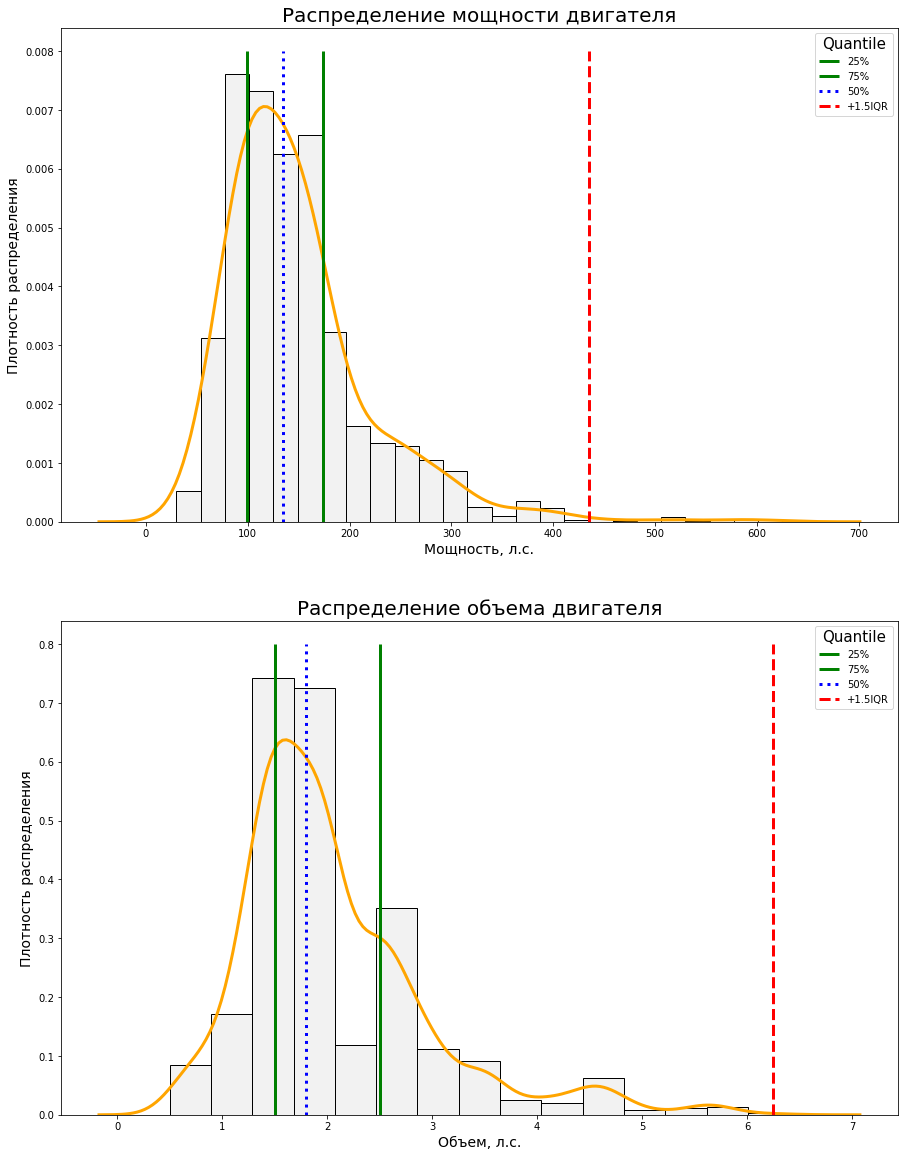

In [80]:

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))


sns.histplot(x = df['power'], bins = 25, color = 'grey', stat='density', alpha=.1, ax=ax[0])
sns.kdeplot(x=df['power'], color='orange',
            linewidth=3, bw_method=.35, ax=ax[0])
ax[0].set_title('Распределение мощности двигателя', fontsize=20)
ax[0].set_xlabel('Мощность, л.с.', fontsize=14)
ax[0].set_ylabel('Плотность распределения', fontsize=14)
ax[0].vlines(np.percentile(df['power'], 25), 0, .008, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[0].vlines(np.percentile(df['power'], 75), 0, .008, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[0].vlines(np.percentile(df['power'], 50), 0, .008, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[0].vlines(np.percentile(df['power'], 75) + 1.5*(np.percentile(df['power'], 75) - np.percentile(df['power'] / 1000, 25)),
             0, .008, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[0].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')


sns.histplot(x = df['engine_displacement'], bins = 15, color = 'grey', stat='density', alpha=.1, ax=ax[1])
sns.kdeplot(x=df['engine_displacement'], color='orange',
            linewidth=3, bw_method=.25, ax=ax[1])
ax[1].set_title('Распределение объема двигателя', fontsize=20)
ax[1].set_xlabel('Объем, л.с.', fontsize=14)
ax[1].set_ylabel('Плотность распределения', fontsize=14)
ax[1].vlines(np.percentile(df['engine_displacement'], 25), 0, .8, linestyles="solid",
             colors="g", linewidth=3, label='25%')
ax[1].vlines(np.percentile(df['engine_displacement'], 75), 0, .8, linestyles="solid",
             colors="g", linewidth=3, label='75%')
ax[1].vlines(np.percentile(df['engine_displacement'], 50), 0, .8, linestyles="dotted",
             colors="b", linewidth=3, label='50%')
ax[1].vlines(np.percentile(df['engine_displacement'], 75) + 1.5*(np.percentile(df['engine_displacement'], 75) - np.percentile(df['engine_displacement'] / 1000, 25)),
             0, .8, linestyles="dashed", colors="r", linewidth=3, label='+1.5IQR')
ax[1].legend(title='Quantile', shadow=False,
             title_fontsize=15, fontsize=10, loc='upper right')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.show()

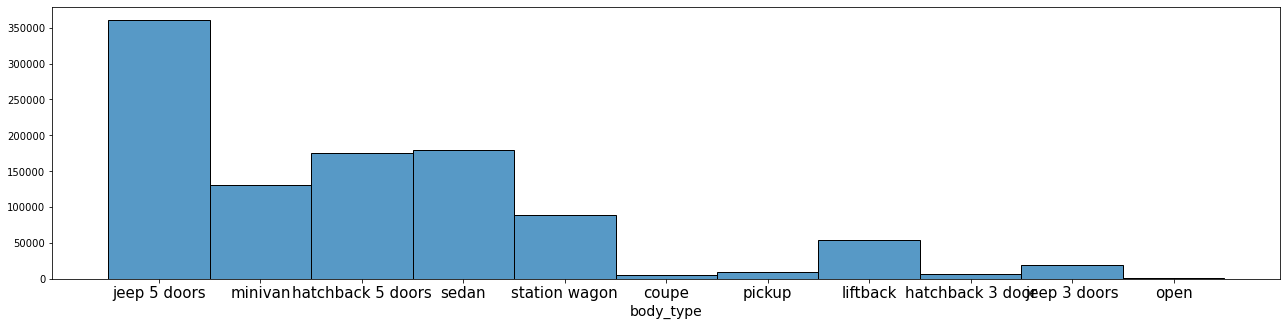

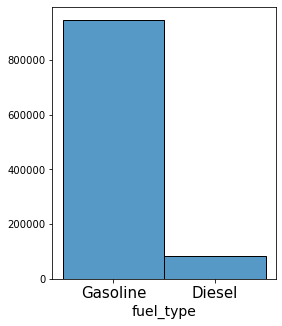

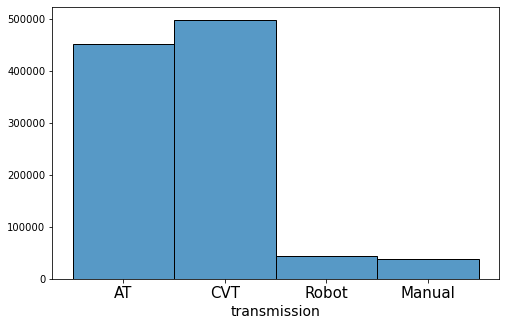

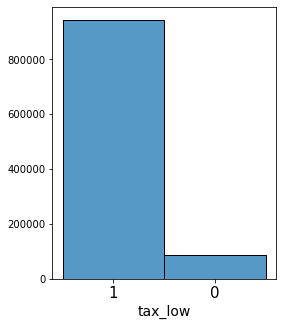

In [88]:
columns = ['body_type', 'fuel_type', 'transmission', 'tax_low']
for col in columns:
    plt.figure(figsize=(df[col].nunique() * 2, 5))
    sns.histplot(data = df, x = col, multiple = 'stack')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('', fontsize=14)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=10)
    plt.show()

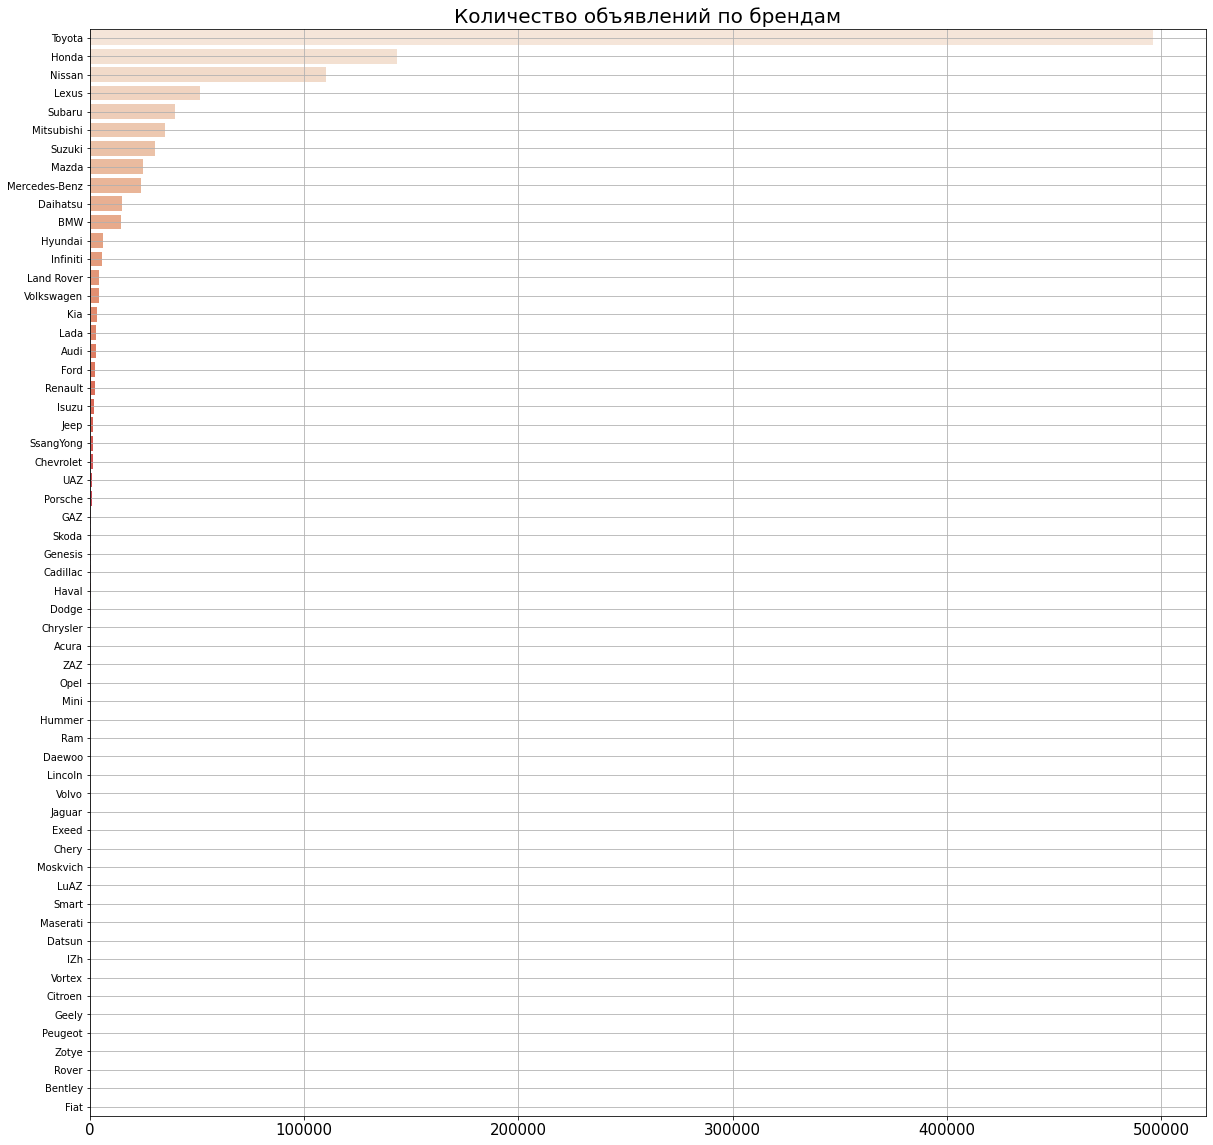

In [89]:
df_pivot_brand = df.pivot_table(index = ['brand'], values = ['name'], 
            aggfunc={'name': 'count'}).sort_values(by='name', ascending = False).reset_index()

plt.figure(figsize=(20, 20))
sns.barplot(data=df_pivot_brand,
           y='brand',
           x='name',
           palette='rocket_r')
plt.grid()
plt.title('Количество объявлений по брендам', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

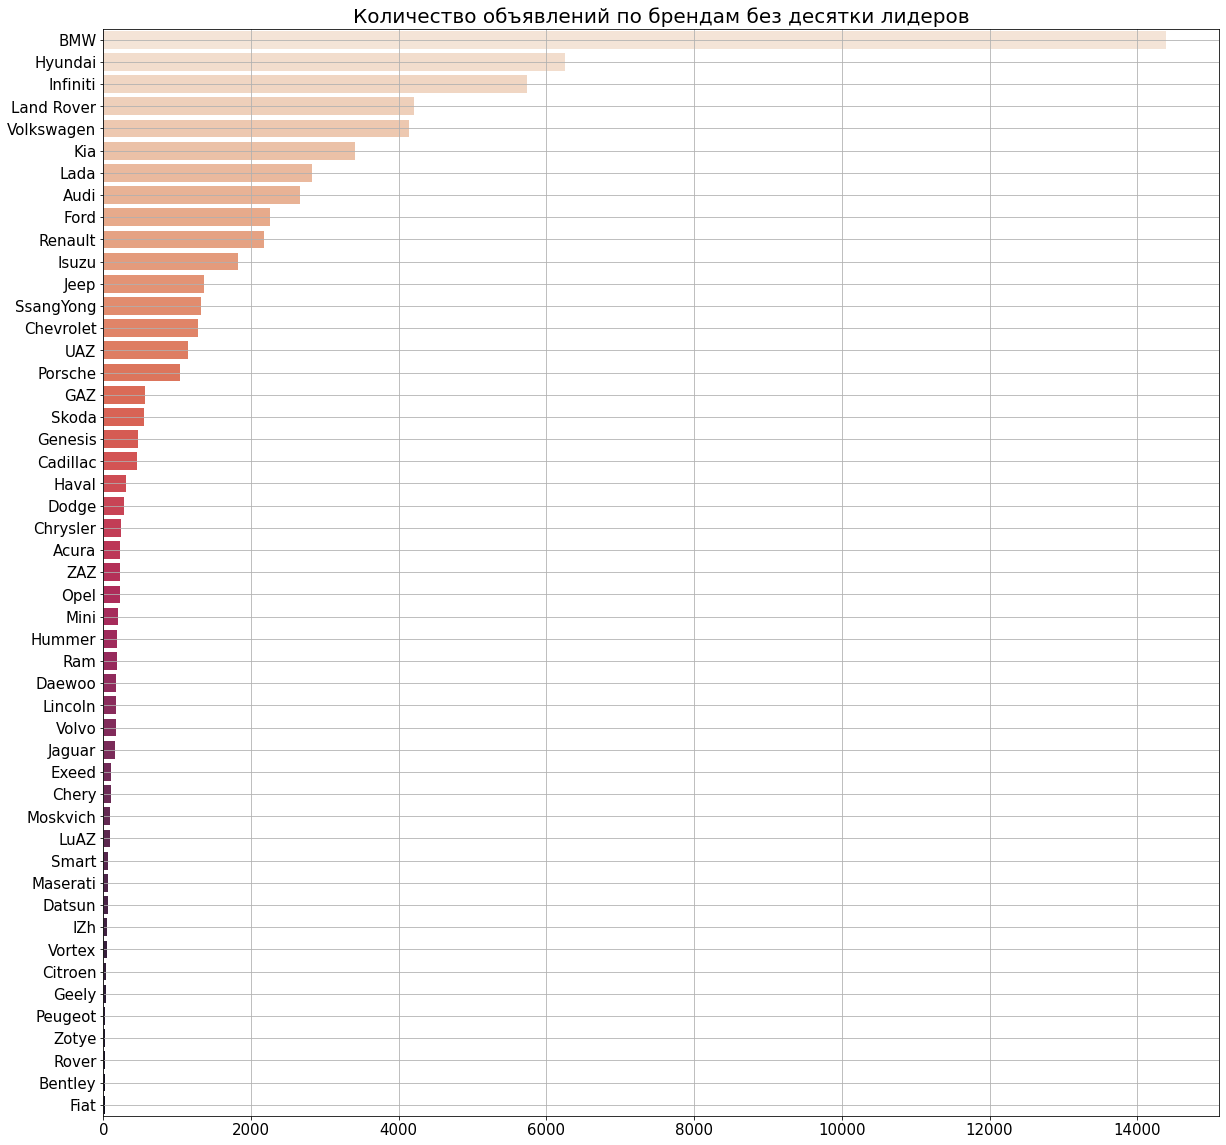

In [90]:
plt.figure(figsize=(20, 20))
sns.barplot(data=df_pivot_brand.loc[10:,:],
           y='brand',
           x='name',
           palette='rocket_r')
plt.grid()
plt.title('Количество объявлений по брендам без десятки лидеров', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

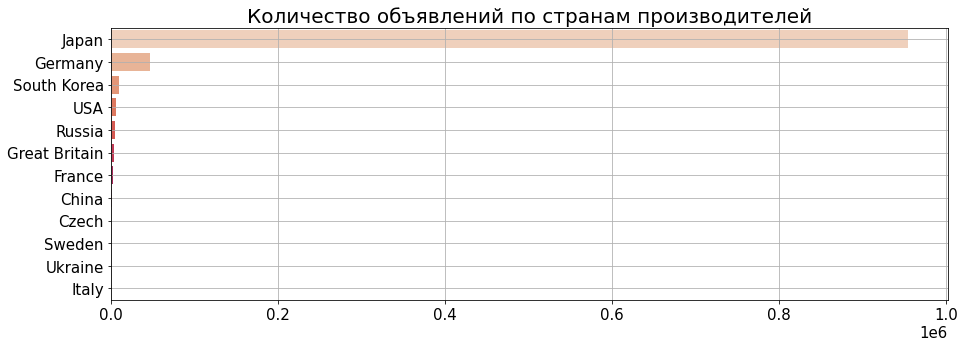

In [91]:
plt.figure(figsize=(15, 5))
sns.barplot(data=df.pivot_table(index=['country'], values=['name'],
                                aggfunc={'name': 'count'}).sort_values(by='name', ascending=False).reset_index(),
            y='country',
            x='name',
            palette='rocket_r')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.grid()
plt.title('Количество объявлений по странам производителей', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

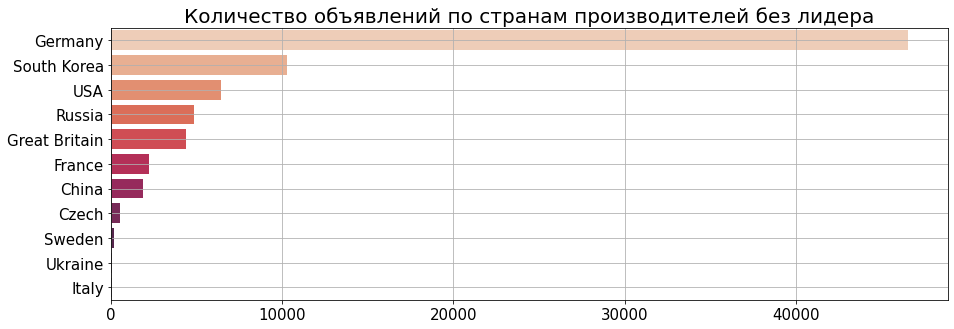

In [92]:
plt.figure(figsize=(15, 5))
sns.barplot(data=df.pivot_table(index=['country'], values=['name'],
                                aggfunc={'name': 'count'}).sort_values(by='name', ascending=False).reset_index().loc[1:, :],
            y='country',
            x='name',
            palette='rocket_r')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.grid()
plt.title('Количество объявлений по странам производителей без лидера', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

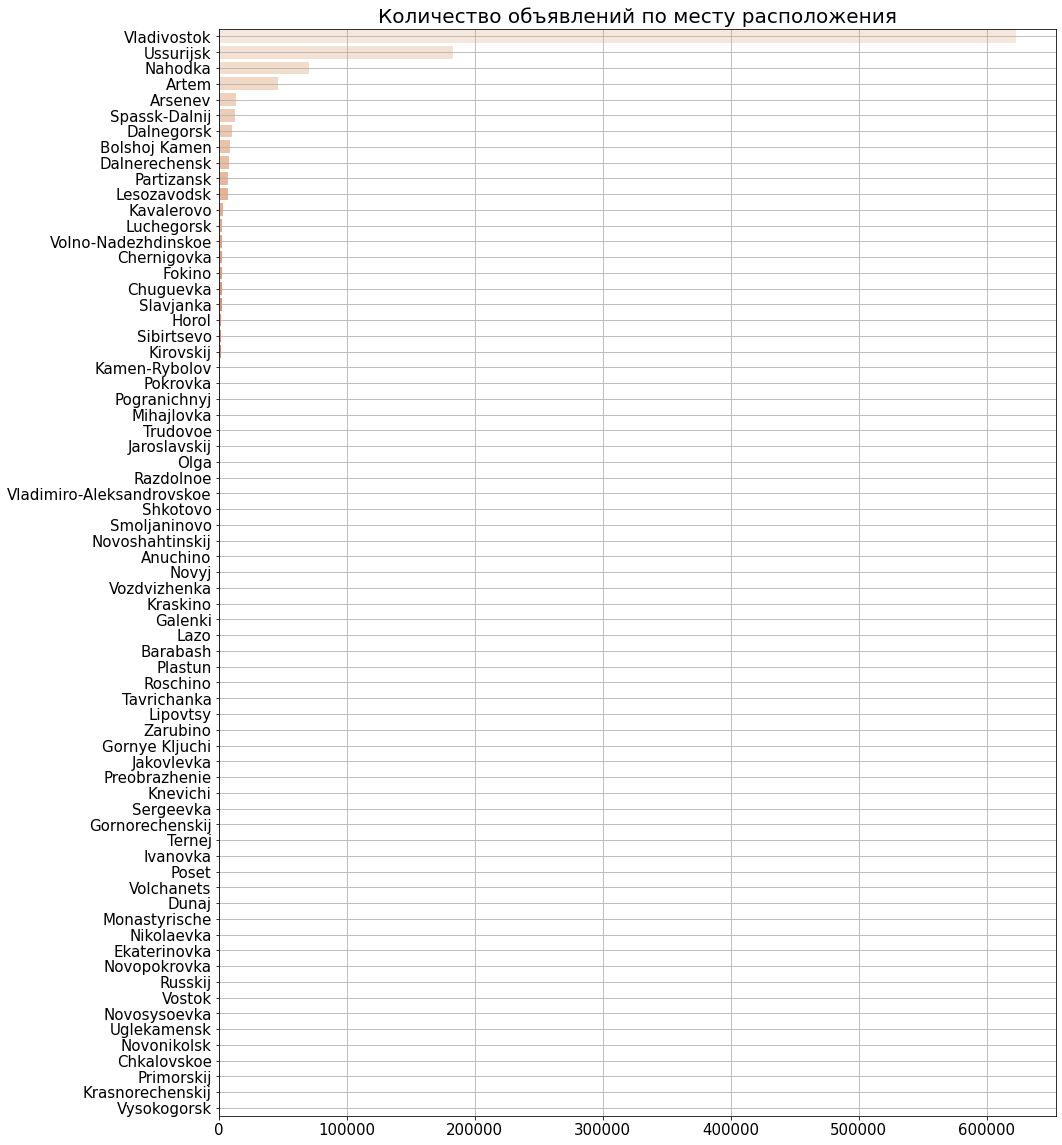

In [93]:
plt.figure(figsize=(15, 20))
sns.barplot(data=df.pivot_table(index = ['location'], values = ['name'], 
                                 aggfunc={'name': 'count'}).sort_values(by='name', ascending = False).reset_index(),
           y='location',
           x='name',
           palette='rocket_r')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.grid()
plt.title('Количество объявлений по месту расположения', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

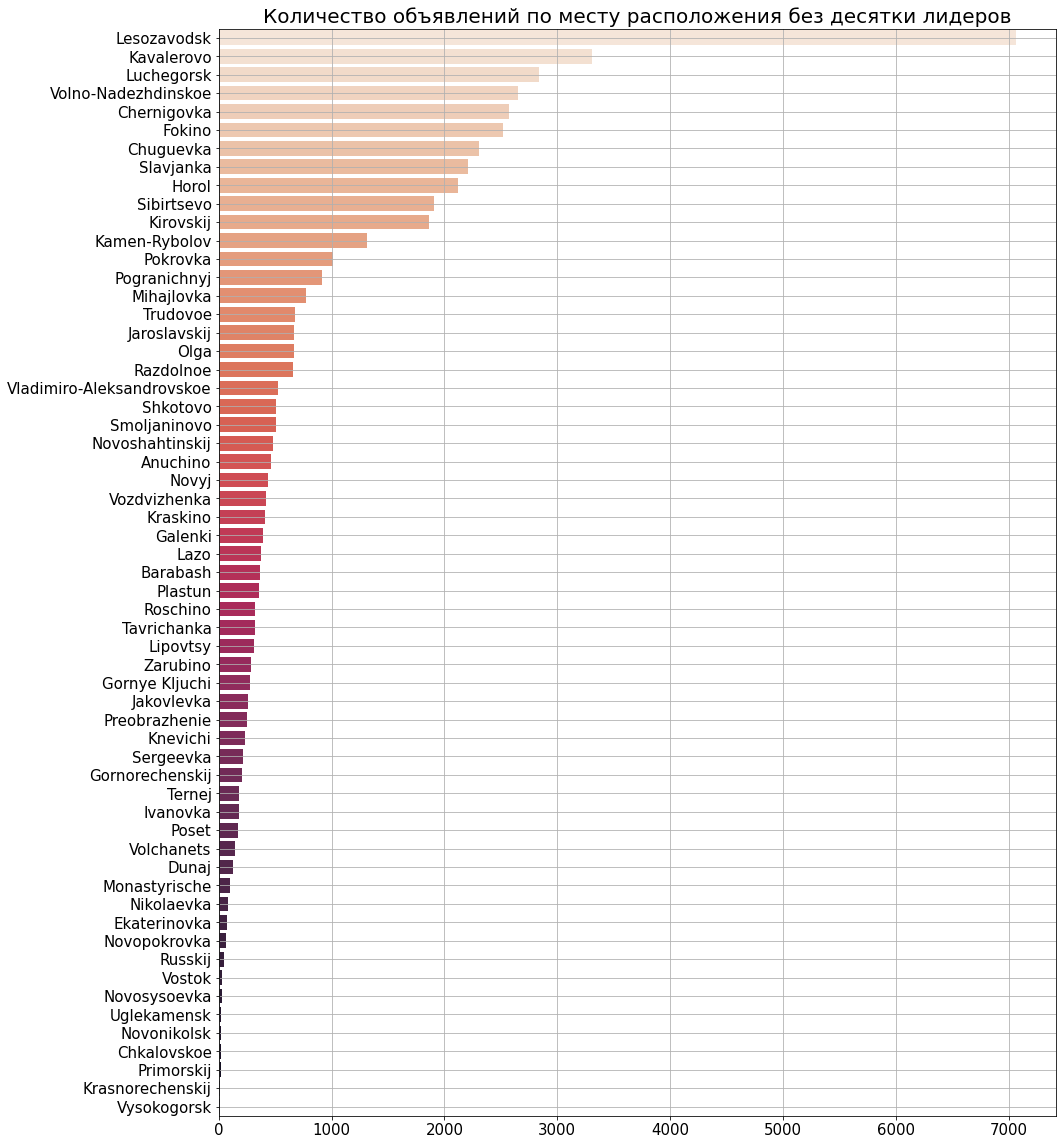

In [94]:
plt.figure(figsize=(15, 20))
sns.barplot(data=df.pivot_table(index = ['location'], values = ['name'], 
                                 aggfunc={'name': 'count'}).sort_values(by='name', ascending = False).reset_index().loc[10:,:],
           y='location',
           x='name',
           palette='rocket_r')
plt.grid()
plt.title('Количество объявлений по месту расположения без десятки лидеров', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [95]:
df_pivot_year = df.pivot_table(index=['year'], values=['name'],
                                aggfunc={'name': 'count'}).sort_values(by='year', ascending=False)


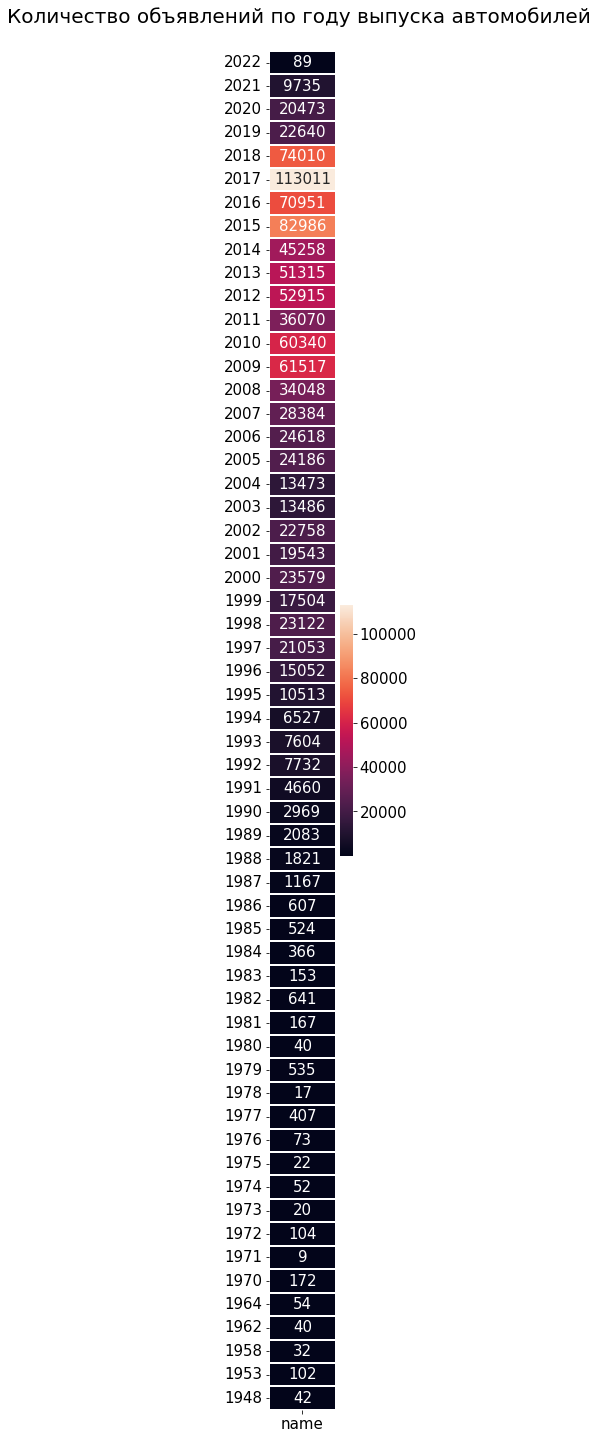

In [96]:
plt.figure(figsize = (1.5, 25))
sns.heatmap(df_pivot_year, annot = True, annot_kws = {'size':15}, linewidth = .02, linecolor = 'white', fmt = '.0f')
plt.title('Количество объявлений по году выпуска автомобилей \n  ', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=0)
plt.rc('ytick', labelsize=15)
plt.show()

In [98]:
df_pivot_lifetime = df.pivot_table(index=['lifetime'], values=['name'],
                                aggfunc={'name': 'count'}).sort_values(by='lifetime', ascending=False)


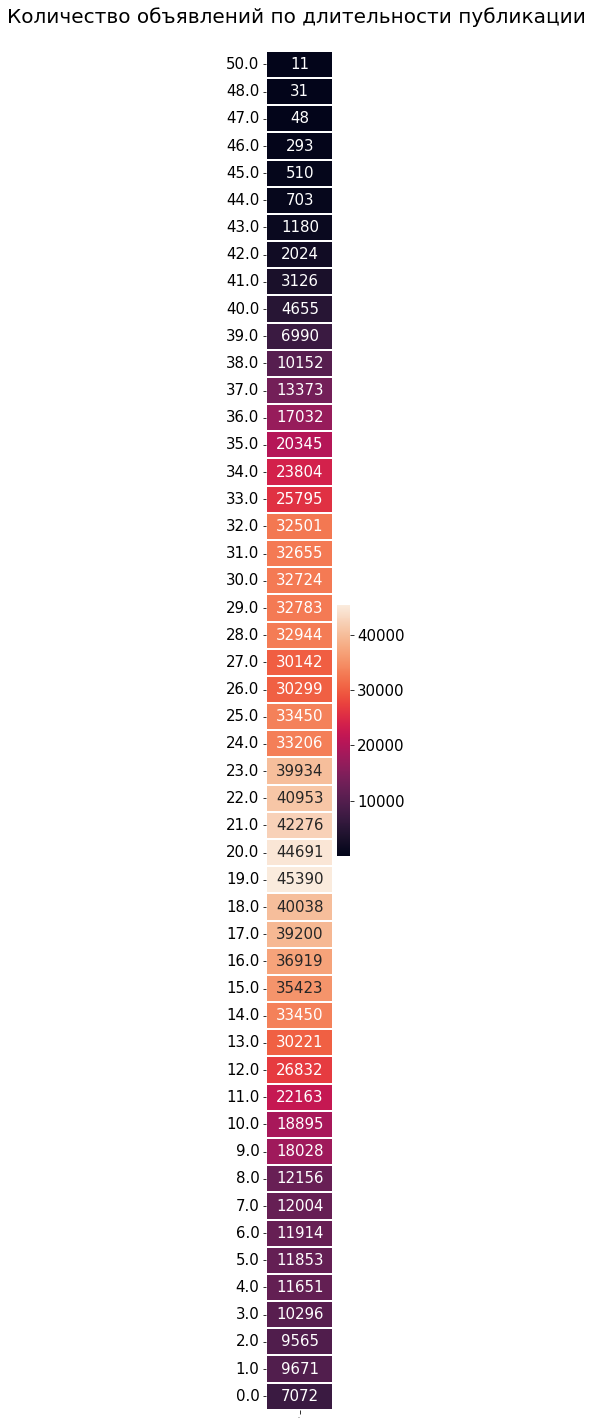

In [99]:
plt.figure(figsize = (1.5, 25))
sns.heatmap(df_pivot_lifetime, annot = True, annot_kws = {'size':15}, linewidth = .02, linecolor = 'white', fmt = '.0f')
plt.title('Количество объявлений по длительности публикации \n  ', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.rc('xtick', labelsize=0)
plt.rc('ytick', labelsize=15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


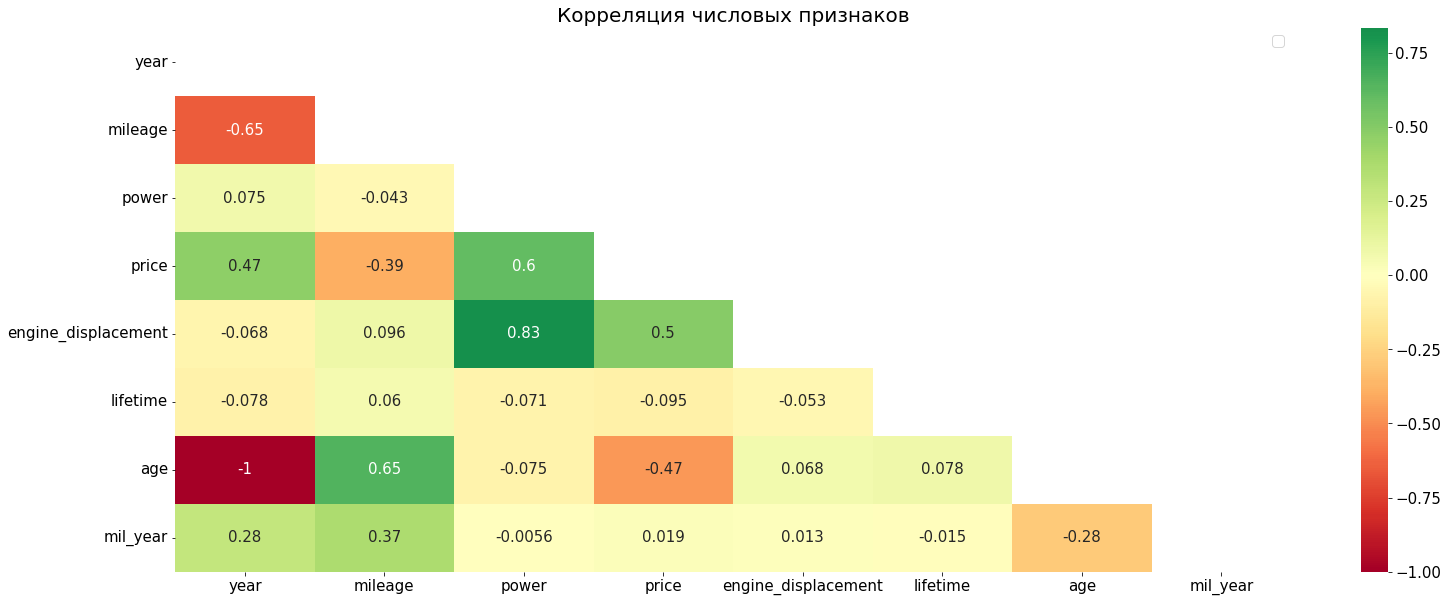

In [97]:
df_corr = df.select_dtypes(include=np.number)
plt.figure(figsize=(25,10))
mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool))
sns.heatmap(df_corr.corr(), xticklabels=df_corr.corr().columns, mask=mask, cmap='RdYlGn', annot_kws = {'size':15}, center=0, annot=True)

plt.title('Корреляция числовых признаков', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [106]:
phik_overview = df.phik_matrix(interval_cols=df_corr)
phik_overview.round(2)


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 5866350. Are interval variables set correctly?
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 8191750. Are interval variables set correctly?
  warnings.warn(


,brand,name,body_type,color,fuel_type,year,mileage,transmission,power,price,vehicle_configuration,engine_name,engine_displacement,location,lifetime,age,mil_year,tax_low,country
brand,1.00,1.00,0.64,0.36,0.44,0.67,0.21,0.68,0.72,0.45,1.00,1.00,0.76,0.48,0.09,0.69,0.15,0.65,1.00
name,1.00,1.00,1.00,0.75,0.84,0.95,0.63,0.94,0.95,0.80,1.00,1.00,0.98,0.88,0.19,0.95,0.52,0.91,1.00
body_type,0.64,1.00,1.00,0.23,0.34,0.34,0.21,0.43,0.49,0.19,1.00,0.96,0.55,0.24,0.05,0.34,0.13,0.26,0.26
color,0.36,0.75,0.23,1.00,0.10,0.27,0.19,0.18,0.22,0.11,0.95,0.74,0.24,0.21,0.05,0.27,0.12,0.14,0.18
fuel_type,0.44,0.84,0.34,0.10,1.00,0.29,0.17,0.46,0.25,0.19,1.00,1.00,0.55,0.09,0.03,0.29,0.04,0.06,0.32
year,0.67,0.95,0.34,0.27,0.29,1.00,0.65,0.53,0.32,0.19,1.00,0.98,0.32,0.35,0.10,1.00,0.25,0.11,0.40
mileage,0.21,0.63,0.21,0.19,0.17,0.65,1.00,0.28,0.20,0.16,0.91,0.77,0.23,0.30,0.08,0.65,0.33,0.03,0.11
transmission,0.68,0.94,0.43,0.18,0.46,0.53,0.28,1.00,0.42,0.17,0.99,0.98,0.46,0.20,0.02,0.52,0.19,0.37,0.50
power,0.72,0.95,0.49,0.22,0.25,0.32,0.20,0.42,1.00,0.54,1.00,1.00,0.89,0.18,0.09,0.32,0.05,1.00,0.47
price,0.45,0.80,0.19,0.11,0.19,0.19,0.16,0.17,0.54,1.00,0.94,0.84,0.34,0.11,0.05,0.19,0.05,0.36,0.29


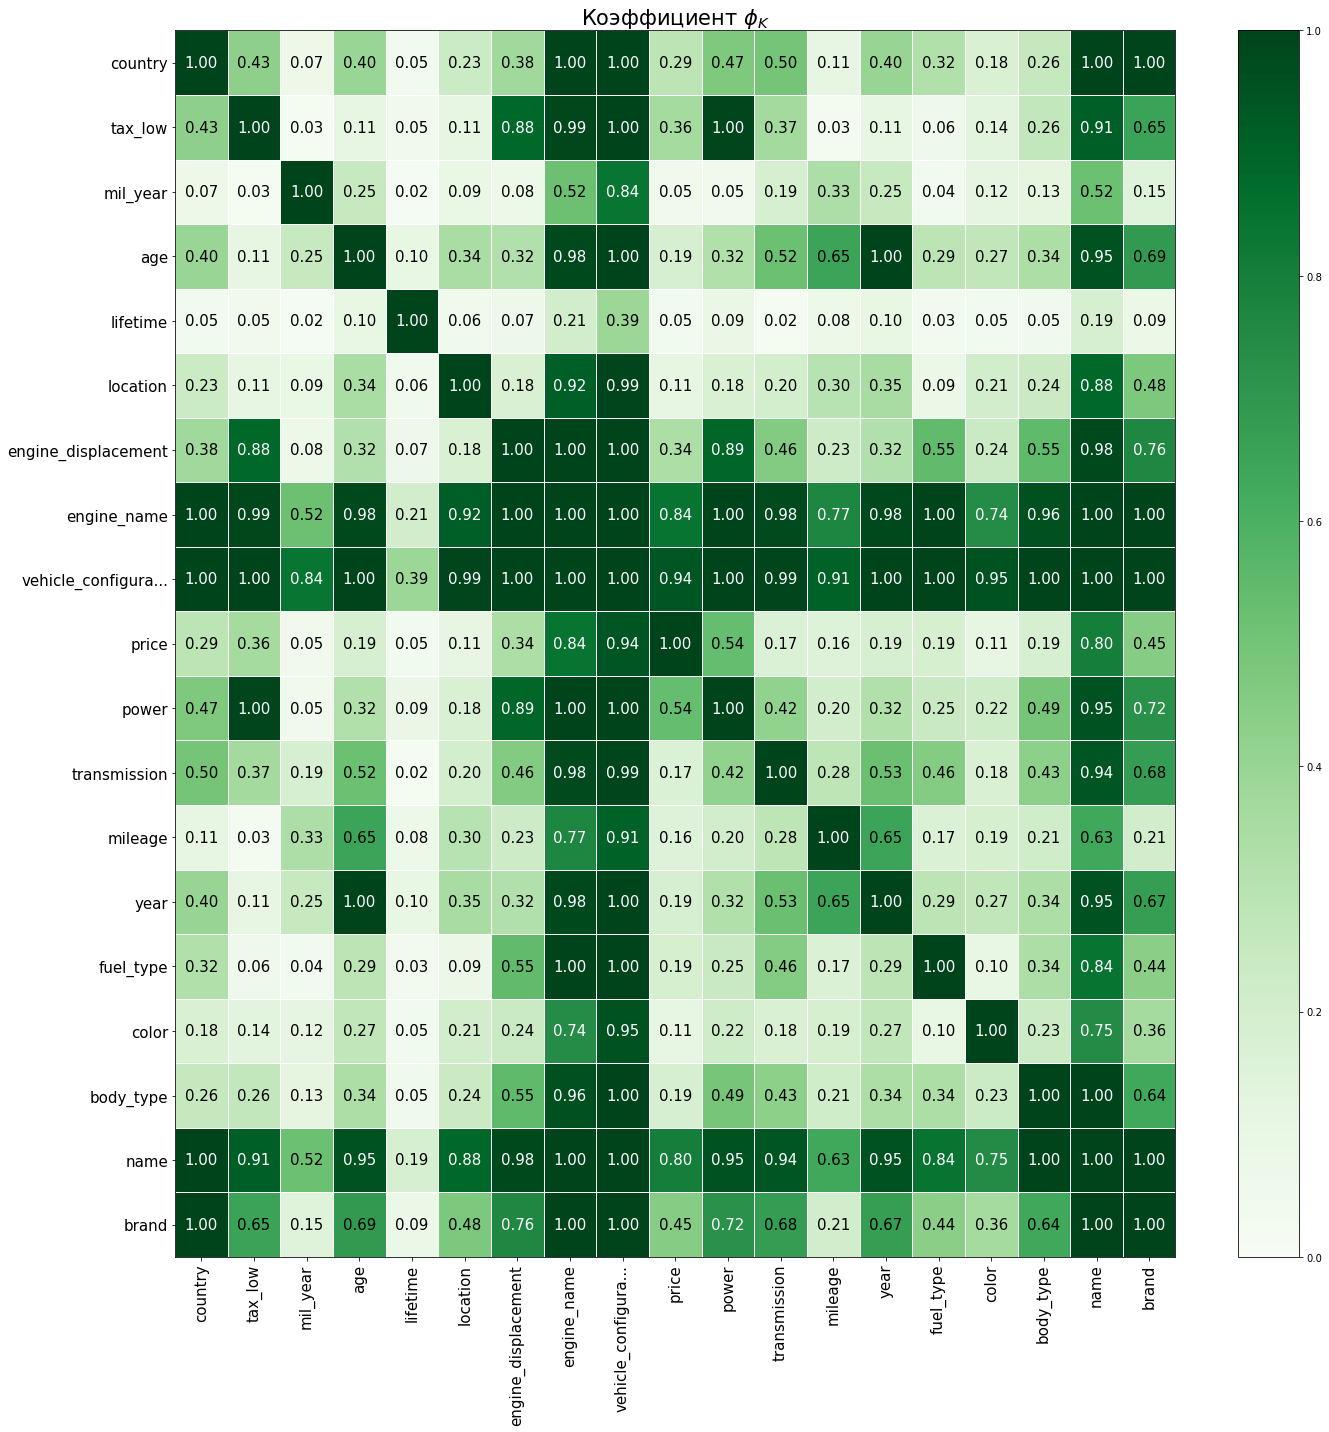

In [107]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Коэффициент $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

In [108]:
significance_overview = df.significance_matrix(interval_cols=df_corr)
significance_overview.round(2)


,brand,name,body_type,color,fuel_type,year,mileage,transmission,power,price,vehicle_configuration,engine_name,engine_displacement,location,lifetime,age,mil_year,tax_low,country
brand,1992.57,1957.15,647.17,326.99,321.70,343.63,210.73,617.98,709.63,335.16,1775.53,1890.33,793.62,265.45,80.05,342.83,145.44,441.54,871.56
name,1957.15,3062.34,1867.01,766.58,586.10,1078.73,663.04,1142.04,1414.70,471.69,2458.71,2648.48,1629.89,609.49,150.32,1078.28,468.39,631.46,852.37
body_type,647.17,1867.01,1917.88,281.99,300.18,437.67,278.18,480.09,744.47,252.40,1746.96,1513.41,824.69,228.70,61.13,438.21,167.93,283.62,286.52
color,326.99,766.58,281.99,1968.43,95.43,294.15,210.29,169.59,250.66,121.32,1239.15,748.62,262.63,190.44,47.41,294.36,114.91,127.03,161.07
fuel_type,321.70,586.10,300.18,95.43,763.54,219.01,123.95,355.82,189.21,152.14,734.92,758.13,381.03,68.06,24.25,219.15,37.28,41.29,196.32
year,343.63,1078.73,437.67,294.15,219.01,1675.14,757.73,579.98,315.83,263.05,1480.66,1285.54,301.87,309.95,94.32,1673.66,351.50,90.93,209.86
mileage,210.73,663.04,278.18,210.29,123.95,757.73,1497.75,307.81,194.01,211.65,1038.21,779.84,211.70,252.63,72.70,757.56,278.58,22.75,139.25
transmission,617.98,1142.04,480.09,169.59,355.82,579.98,307.81,1414.60,482.00,204.27,1298.53,1256.76,538.68,158.75,24.53,579.65,215.43,258.77,364.95
power,709.63,1414.70,744.47,250.66,189.21,315.83,194.01,482.00,1737.83,388.05,1619.88,1650.62,1154.90,183.83,81.11,315.61,64.36,732.97,402.32
price,335.16,471.69,252.40,121.32,152.14,263.05,211.65,204.27,388.05,658.64,528.98,496.06,348.19,129.78,54.65,263.05,45.52,267.23,224.46


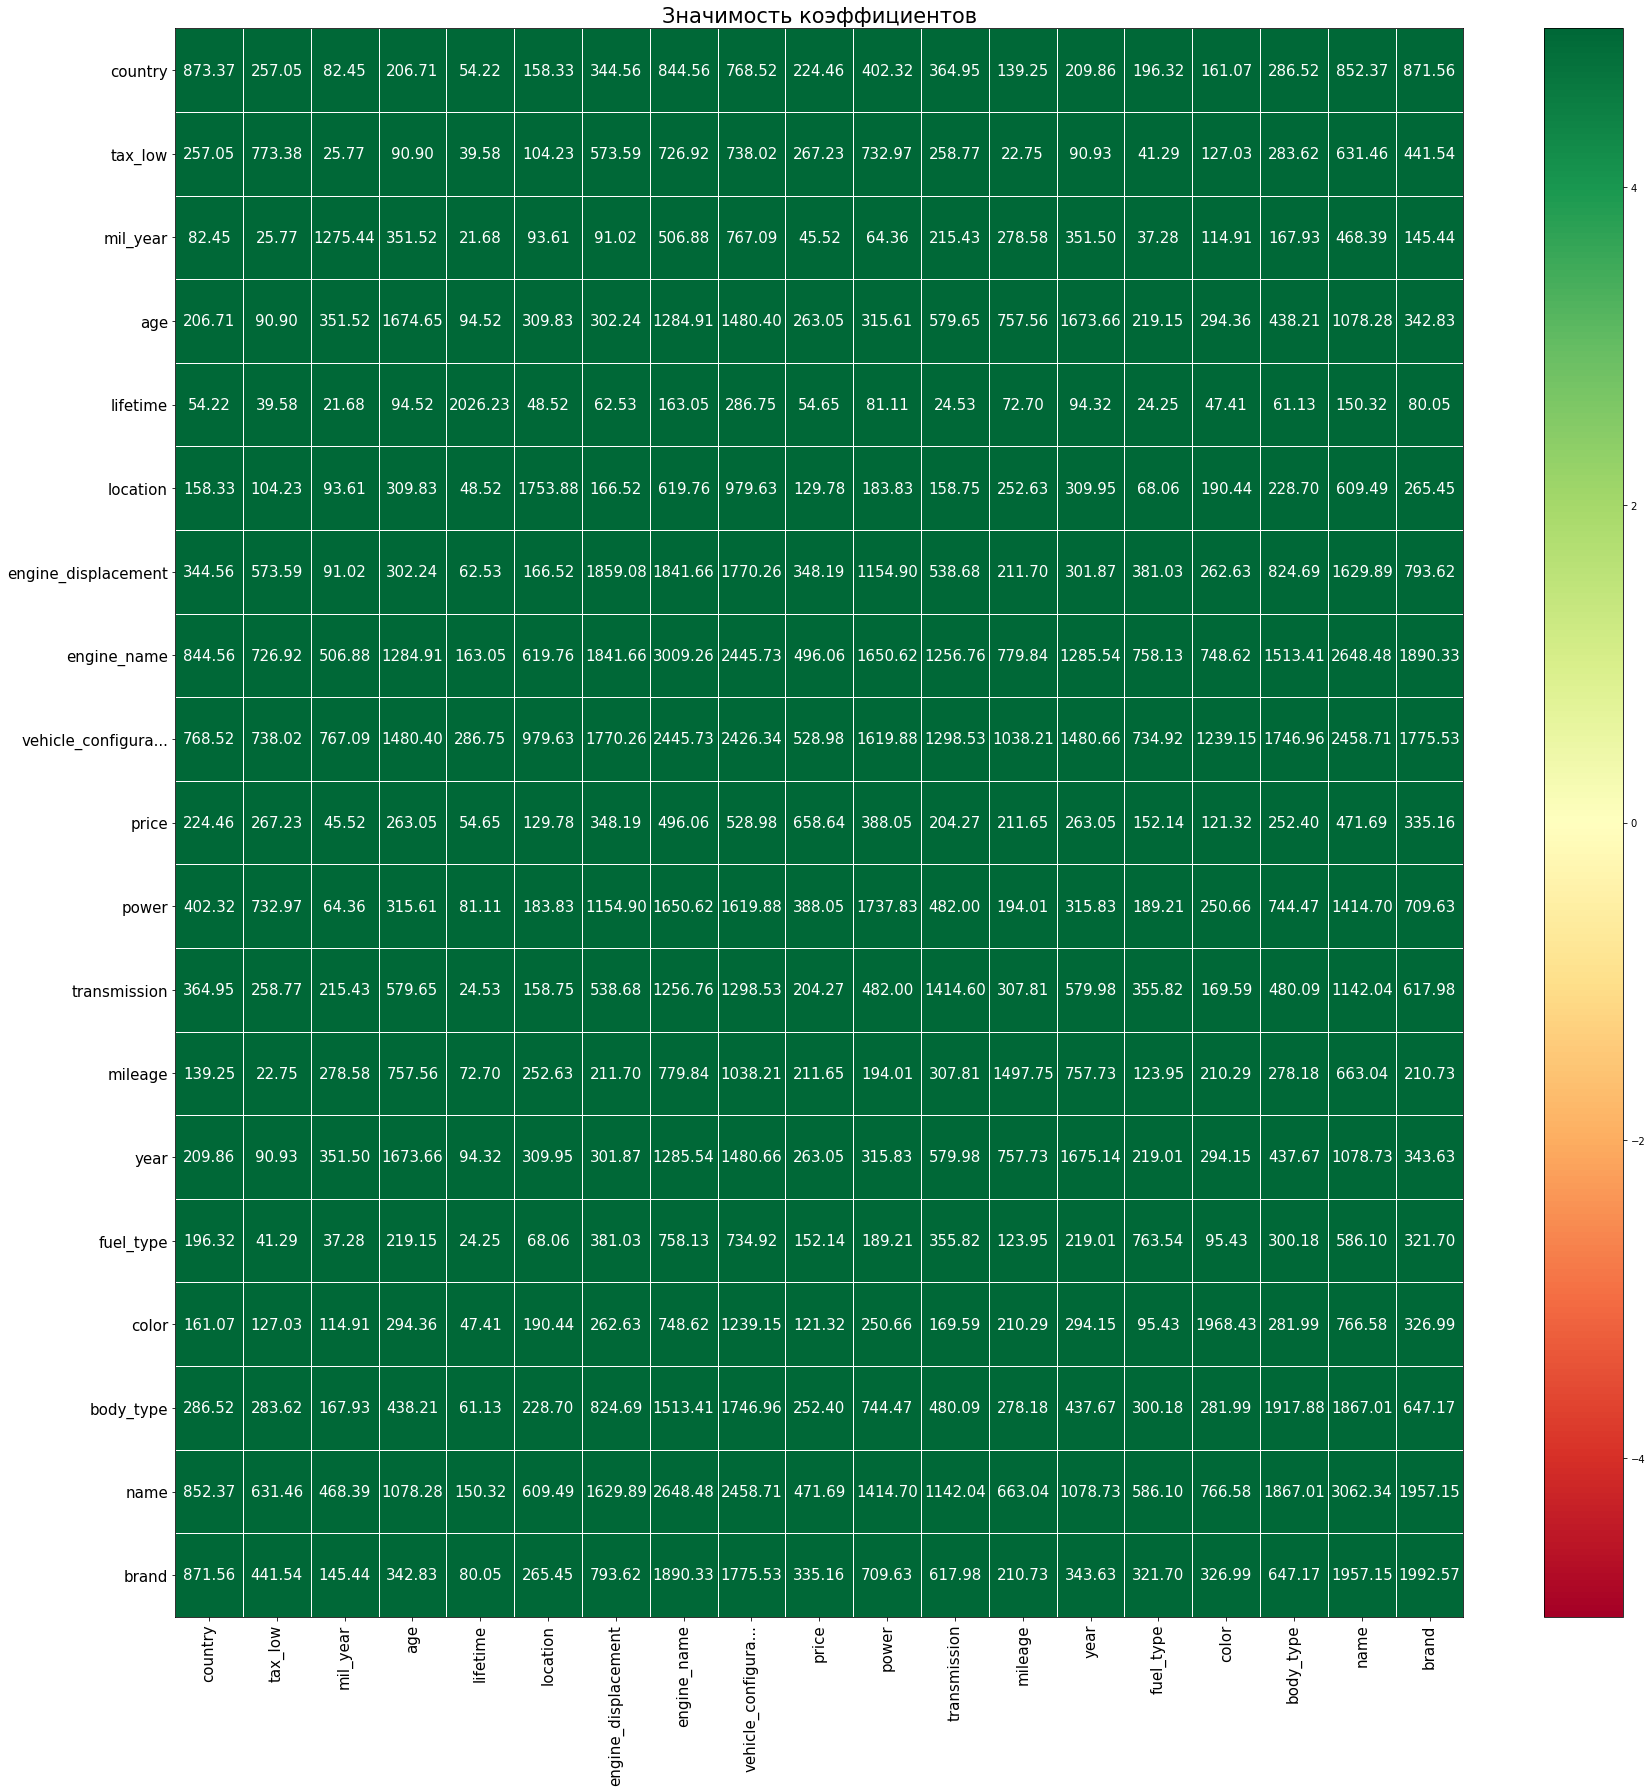

In [109]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Значимость коэффициентов", 
                        usetex=False, fontsize_factor=1.5, figsize=(25, 25))
plt.tight_layout()

Учитывая ненормальное распределение числовых показателей, в качестве центральной меры буду рассматриваться медиана и межквариьлный промежуток.

- В объявлениях представлены автомобилями от 1948 до 2022 годов выпуска. Большая часть автомобилей сосредоточена в области 2012 (10 лет) года выпуска (iqr = 10 лет). 98% выборки находится в диапазоне от 1990 (32 года) по 2020 (2 года) годов выпуска. Мы видим смещение выборки в сторону возрастных автомобилей, с довольно внушительным хвостом. Самым многочисленными являются объявления о продаже автомобилей возрастом 6 лет (113 011).
- Судя по пробегу автомобиля в объявлениях представлены автомобили как относительно новые (min = 1000 км.), так и после довольно внушительной эксплуатации (max = 1 000 000 км.). БОльшая часть выборки сосредоточена вокруг медианы в 119 000 км (iqr = 110 000 км.). 98% выборки сосредоточено в диапазоне от 1000 до 350 000 км. Выборка смещена вправо, в сторону бОльшего пробега с внушительным широким хвостом. 
- Самый распространенный среднегодовой пробег 11 250 км./год (iqr = 7 077 км./год). Самый внушительный среднегодовой пробег 125 000 км./год, тогда как минимальный 14 км./год. В 98% объявлений среднегодовой пробег сосредоточен в корридоре значений от 77 до 30 000 км./год. По данным интерфакс на 19.08.2022 среднегодовой пробег автомобилей во Владивостоке составляет 18 700 км., что характерно для использования автомобиля в личных целях, а не рабочих (например такси).
- Распределение автомобилей по мощности ДВС близко к нормальному, однако смещено вправо. Представлены автомобили мощностью от 30 до 625 л.с. Большая часть автомобилей сосредоточена в диапазоне от 99 до 174 л.с. (медиана 135 л.с., iqr = 75 л.с.). 98% выборки сосредоточено в диапазоне от 52 до 405 л.с. 
- Самым распространенным объемом двигателя среди продаваемых автомобилей 1,8 л (iqr = 1 л.). Распределение объема ДВС смещена вправо, в сторону бОльших значений. 98% значений сосредоточено в диапазоне от 0,7 до 5,5 л. Максимальные и минимальные объемы двигателя 6,4 и 0,5 л соответственно.
- Распределение длительности публикации о продаже автомобиля смещено влево, в сторону меньшего значения. Самое длительное объявление активно 50 часов, тогда как самое новой опубликовано в одно время с сбором данных. Самым распространеным значением является 21 час (iqr = 14 часов). 98% значений сосредоточено в диапазоне от 1 до 40 часов. 
- Вариабльнее всего представлены данные о стоимости автомобилей. Самым дорогим, по оценке продавца, является автомобиль стоимостью 41 500 000 рублей, тогда как самый бюджетный был оценен в 20 000 рублей. Распределение сильно смещено вправо, в сторону большей стоимости. Самой распространенной оценкой продаваемого транспортного средства является 950 000 рублей (iqr = 1 240 000 рублей). 98% значений сосредоточено от 100 000 до 7 800 000 рублей. Выбросы по стоимости автомобиля сосредоточены в большей степени до 10 млн. рублей.
- Самым предпочтительным с точки зрения типа кузова среди автомобилей, выставленных на продажу, является пятидверный внедорожник. Далее следуют седаны и пятидверные хэтчбеки, а замыкают пятерку лидеров минивены и универсалы.
- Самым распространенным типом топлива для ДВС является бензин. Дизель используется в чуть более 10% представленных автомобилей.
- Примерно такое же соотношение между автомобилями с низким и высоким тарифами налогооблажения.
- Чаще всего автомобили оснащаются трансмиссиией типа вариатор. Следом за ним коробка автомат. Роботизированная и механическая коробки передач замыкают хит-парад с довольно близким соотношением представителей.
- Среди стран производителей с более чем 90% долей представителей лидирует Япония. Следом за ней Германия, с чуть более 45 000 представителей в выборке. Замыкают пятерку лидеров Южная Корея, США и Россия. 
- С большим отрывом в половину представленнх объявлений лидируют автомобили марки Toyota. Первая восьмерка лидеров представлена экспансией японских автомобилей: Honda, Nissan, Lexus, Subaru, Mitsubishi, Suzuki, Mazda. Замыкают десятку лидеров Mercedes-Benz и Daihatsu. Доля лидеров брендов настолько велика, что для рассмотрения остальных представителей необходима визуализация без топ 10 представителей. Следующим за лидерами с довольно внушительным отрывом идут машины марки BMW (чуть более 14 000 представителей). Далее следуют Hyundai и Infiniti, Land Rover и Volkswagen. Удивительно, что лидеры по распространенности во всей стране Kia и Lada занимают лишь 16 и 17 места соответственно. Месторасположение значительно влияет на распространенние автомобилей японского автопрома в регионе. 
- Чаще всего автомобили в Приморском края продают во Владивостоке (более 600 000 объявлений). Далее следует тройка очевидных лидеров: Усурийск (около 180 000), Находка (около 70 000) и Артем (около 50 000). Десятку лидеров замыкают: Арсенев, Спасск-Дальний, Дальнегорск, Большой камень и Дальшереченск. Открывает второй эшелон с большим отрывом от следующих представителей Лесозаводск (около 7 000).
- При оценке связи признаков при помощи корреляционного коэффициента Пирсона выяснилось, что возраст автомобилей  и пробег обладают средней отрицательной корреляционной связью со стоимостью автомобилей. Сильнее всего со стоимостью автомобиля положительно связаны мощность и объем ДВС (0,6 и 0,5 соответственно). Среднегодовой пробег и длительность публикации не связаны со стоимостью автомобилей. 
- При оценке корреляции между признаками при помоощи Фи коэффициента выявленая сильная положительная корреляция между моделью и стоимостью автомобиля (0,8), и положительная связь средней силы между маркой и стоимостью автомобиля (0,45). Также выявленая сильная положительная связь между конфигурацией автомобиля (0,94) и моделью двигателя (0,84) со стоимостью автомобиля. Выявлена положительная корреляция слабой силы между страной производителя (0,29) и таримоф налогооблажения (0,36) со стоимостью автомобиля.
- Также сильной положительной связью обладают такие признаки как модель и марка автомобиля с тарифом на налог за владением транспортным средством (0,91 и 0,65 соответственно). Удивительно, но меторасположение продаваемого траспортного средства сильно положительно связана с моделью двигателя (0,92) и конфикурацией автомобиля (0,99). Также, возраст автомобиля сильно связан с моделью (0,95) и маркой (0,69) автомобиля. Данный факт является занимательным, так как у большинства производителей многие модели имеют несколько поколений, значительно отличающихся друг от друга по возрасту автомобилей. Страна производителя облает слабой положительной связью с такими признаками как: тариф на налог, возраст автомобиля, объем двигателя, тип трансмиссии и год выпуска.


**"Портрет" среднестатистического объявления о продаже автомобиля в Приморском крае на портале drom.ru:**
- Длительностью публикации 21 час, японский пятидверный внедорожник, марки Toyota,  2012 (10 лет) года выпуска с пробегом около 119 000 км, мощностью 135 л/с, объемом бензинового двигателя 1,8 л, трансмиссией типа вариатор, низким тарифом налооблажения на владение транспортным средством, среднегодовым пробегом около 11 250 км., вероятнее использовавшийся в личных целях.

In [ ]:
# df.to_csv('/Users/prime/Documents/data/Resume/sales cars/eda_sales_cars.csv', index=False)